# Vacuum Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import numpy as np

from scipy.optimize import curve_fit

from qs_mps.mps_class import MPS
from qs_mps.utils import tensor_shapes, von_neumann_entropy, load_list_of_lists, get_precision, create_sequential_colors

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 12
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True
# Set global font properties
font = {'family': 'serif', 'size': 12}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "mac"
cx = [3,37]
cy = [3,3]
cx = None
cy = None

if model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"
else:
    raise SyntaxError("Model not valid. Choose 'Z2_dual'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    parent_path = f"C:/Users/HP/Desktop/projects/1_Z2"
    # parent_path = "G:/My Drive/projects/1_Z2"
    path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    # path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    # parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

## Critical Point - Quantum Info

### Entropy for different bond dimensions $\chi$

In [6]:
L, l, hx_i, hx_f, npoints, lx, ly = 6, 6, 0.4, 0.7, 50, 2, 2 
chis = [4, 16, 64, 128, 512]

lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

In [ ]:
entr_tot = []
if retrieve:
    for chi, entropy in zip(chis, entropy_chi):
        entr_h = entropy
        idx_max = np.argmax(entr_h)
        g_max = round(interval[np.argmax(entr_h)],4)
        plt.plot(interval, entr_h, label=f"$\chi={chi}$, max: ${g_max}$")
        entr_tot.append(entr_h)
        
else:
    for chi in chis:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        entr_h = [von_neumann_entropy(sm) for sm in sm_h]
        idx_max = np.argmax(entr_h)
        g_max = round(interval[np.argmax(entr_h)],4)
        plt.plot(interval, entr_h, label=f"$\chi={chi}$, max: ${g_max}$")
        entr_tot.append(entr_h)

if log:
    plt.xscale('log')
# plt.yscale('log')
plt.title(f"Entropy for ${l}$x${L}$ direct lattice - Max at ${g_max}$");
plt.legend()
# plt.savefig(f"{parent_path}/figures/entropy/{L//2}_bond_entropy_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.png");

### Entropy difference

In [ ]:
i = 0
entr_tot = np.asarray(entr_tot)
for chi, entr in zip(chis, entr_tot):
    if i < (len(chis)-1):
        entr_diff = np.abs(entr_tot[-1]-entr_tot[i])
        plt.plot(interval, entr_diff, 'x', alpha=0.8, label=f"diff $\chi$: {chis[-1]}-{chis[i]}")
        i += 1
plt.legend()
if log:
    plt.xscale("log")
plt.yscale("log")
plt.savefig(f"{parent_path}/figures/entropy/{L//2}_bond_entropy_difference_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}.png");

### Entropy decay at maxima of the Entropy

In [ ]:
schmidt_vals_chi = []
for chi in chis:
    if retrieve:
        lattice = MPS(L=L, d=2**l, chi=chi, h=interval[idx_max], model="Z2_dual", bc=boundcond)
        lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=precision)
        lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
        sm_h = lattice.bonds[lattice.L // 2].copy()
        schmidt_vals_chi.append(sm_h)
    else:
        sm_h = np.load(f"{parent_path}/results/entropy_data/{L//2}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        sm_h = sm_h[idx_max,:]
        schmidt_vals_chi.append(sm_h)
    plt.plot(sm_h, label=f"$\chi={chi}$")
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.show()

### Entropy for different Lattices

In [9]:
Ls = [4, 5, 6, 7]
ls = Ls
chis = [64, 64, 64, 64]
hx_i, hx_f, npoints = 0.5, 0.6, 101
lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

In [ ]:
entr_tot = []
colors = ['#52b69a', '#168aad', '#1e6091']
colors = ['#99d98c', '#52b69a', '#168aad', '#1e6091']
colors = ['#99d98c', '#52b69a', '#168aad', '#1e6091', '#d9ed92']

i = 0
g_maxs = []
for chi, L, l in zip(chis, Ls, ls):
    if L%2 == 1:
        bond_site = L//2 + 1
    else:
        bond_site = L//2
    sm_h = np.load(f"{parent_path}/results/entropy_data/{bond_site}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy", allow_pickle=True)
    sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
    entr_h = [von_neumann_entropy(sm) for sm in sm_h]
    g_max = round(interval[np.argmax(entr_h)], 4)
    g_maxs.append(g_max)
    plt.plot(interval, entr_h, color=colors[i], label=f"${l}$x${L}$, bc: {boundcond}") #  $\chi={chi}$; max: ${g_max}$
    plt.scatter(g_max, np.max(entr_h), marker='o', facecolors="white", edgecolors="red")
    entr_tot.append(entr_h)
    i += 1


plt.grid(True, alpha=0.5)
plt.legend()
plt.ylabel("$S(\\rho^I)$")
if log:
    plt.xscale('log')
plt.show()

### Thermodynamic Extrapolation

In [ ]:
# Your given data
Ls_inv = [1/4, 1/5, 1/6, 1/7]
entr_max = []
idx_max = []
for entr, L in zip(entr_tot, Ls):
    entr_max.append(np.max(entr))
    idx_max.append(np.argmax(entr))

# Linear fit function
def lin(x, a, b):
    return a * x + b

# Error on x
x_err = (hx_f - hx_i) / npoints
crit_vals_err = np.array([x_err] * len(idx_max))

# Perform the linear fit
xdata = Ls_inv
ydata = interval[idx_max]
p_opt, c_opt = curve_fit(lin, xdata, ydata, sigma=crit_vals_err, absolute_sigma=True)

# Extract the optimal parameters
a_opt, b_opt = p_opt

# Extract the standard errors of the parameters
perr = np.sqrt(np.diag(c_opt))
a_err, crit_err = perr

# Print the results
print(f"Optimal parameters: a = {a_opt:.4f} ± {a_err:.4f}, b = {b_opt:.4f} ± {crit_err:.4f}")

# Theoretical and fitted critical points
h_th = 1 / np.sqrt(3.044)
h_c = lin(x=0, a=p_opt[0], b=p_opt[1])

In [12]:
def plotting(p_opt, perr, xdata, ydata, crit_vals_err, colors):
    # Data for the fit line and error bounds
    xs = np.linspace(0, 0.3)
    y_fit = lin(xs, p_opt[0], p_opt[1])
    y_err_plus = lin(xs, p_opt[0] + perr[0], p_opt[1] + perr[1])
    y_err_minus = lin(xs, p_opt[0] - perr[0], p_opt[1] - perr[1])

    # Plotting
    fig, ax = plt.subplots()
    ax.plot(xs, y_fit, color=colors[0], linewidth=1, label=f'Fit: {p_opt[0]:.2f}/L + {p_opt[1]:.2f}')
    # ax.fill_between(xs, y_err_minus, y_err_plus, color=colors[1], alpha=0.5, label="Fit Uncertainty")
    ax.errorbar(xdata, ydata, yerr=crit_vals_err, fmt='o', elinewidth=1, capsize=6, markersize=4, color=colors[2], label="Data")

    ax.scatter([0], [h_th], marker='x', color=colors[3], s=40, label="$g_c^{th}$")
    ax.errorbar([0], [h_c], yerr=perr[1], fmt='s', elinewidth=1, capsize=6, markersize=5, color=colors[4], label="$g_c^{fit}$")
    ax.set_xlabel("$1/L$", fontsize=14)
    ax.set_ylabel("electric coupling $(g)$", fontsize=14)
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize=14)
    ax.set_ylim(bottom=0.45)
    
    # Inset plot
    inset_ax = inset_axes(ax, width="42%", height="45%", loc="lower left", bbox_to_anchor=(0.09, 0.09, 0.95, 0.9), bbox_transform=ax.transAxes)
    colors = ['#99d98c', '#52b69a', '#168aad', '#1e6091', '#d9ed92']

    i = 0
    g_maxs = []
    for chi, L, l in zip(chis, Ls, ls):
        if L%2 == 1:
            bond_site = L//2 + 1
        else:
            bond_site = L//2
        sm_h = np.load(f"{parent_path}/results/entropy_data/{bond_site}_schmidt_vals_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy", allow_pickle=True)
        sm_h = sm_h.reshape((npoints, sm_h.shape[-1]))
        entr_h = [von_neumann_entropy(sm) for sm in sm_h]
        g_max = round(interval[np.argmax(entr_h)], 4)
        g_maxs.append(g_max)
        inset_ax.plot(interval, entr_h, color=colors[i], label=f"${l}$x${L}$")
        inset_ax.scatter(g_max, np.max(entr_h), marker='o', facecolors="white", edgecolors="red")
        entr_tot.append(entr_h)
        i += 1

    inset_ax.grid(True, alpha=0.5)
    inset_ax.legend(fontsize=10, loc='upper right')
    inset_ax.set_xlabel("electric coupling $(g)$", fontsize=14)
    inset_ax.set_ylabel("$S(\\rho^I)$", fontsize=14)
    inset_ax.tick_params(axis='both', which='major', labelsize=8)
    inset_ax.tick_params(axis='both', which='minor', labelsize=8)

    # Save the plot
    plt.savefig(f"{parent_path}/figures/entropy/extrapolation_critical_point_Z2_dual_L_{Ls}_{sector}_bc_{boundcond}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}.png")

    plt.show()

In [ ]:
colors = ['#023047', '#8ECAE6', '#219EBC', 'red', '#FFB703'] # line dark, std light, data bright, g_th, g_fit
# colors = ['#8ECAE6', '#8ECAE6', '#023047', 'red', '#FFB703'] # line light, std light, data dark
# colors = ['#f4a261', '#e9c46a', '#2a9d8f', 'red', '#e76f51']
# colors = ['#073b4c', '#06d6a0', '#118ab2', '#ef476f', '#ffd166']
plotting(p_opt, perr, xdata, ydata, crit_vals_err, colors)

### Scaling of Entanglement with Area Law

The system is $2D$ but the MPS that we use is taking into account the number of ladders. We could try then
$$S(\rho^I) = \Omega(log_2(n))$$
where $n$ is the number of d.o.f in the subsystem $I$, that is $(L//2)  l$. 

In [ ]:
Ls = [4,5,6,7]

def area_law(n, a, b):
    return b + a*np.log(n)


x_data = [(L//2)*L for L in Ls]
# x_data = [(L/2) for L in Ls]
y_data = [np.max(entr) for entr in entr_tot]

p_opt, c_opt = curve_fit(area_law, x_data, y_data)
perr = np.sqrt(np.diag(c_opt))
a_err, b_err = perr

print(f"Should the coefficient in front of the logarithm connected with the central charge?\n c/3=1/6={1/6}")
print(f"experimental coefficient: {p_opt[0]} ± {a_err}")
plt.plot(x_data, y_data, 'x')
plt.plot(np.linspace(x_data[0],x_data[-1]), area_law(np.linspace(x_data[0],x_data[-1]), p_opt[0], p_opt[1]))
plt.xlabel("degrees of freedom of the subsystem $\\rho^I$")
plt.ylabel("$S(\\rho^I)$")
plt.savefig(f"{parent_path}/figures/entropy/CFT_entanglement_scaling_Z2_dual_L_{Ls}_{sector}_bc_{boundcond}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}.png")


## Critical Point - Statistical Physics

In [60]:
Ls = [4, 5, 6, 7]
ls = Ls.copy()
chis = [64, 64, 64, 64]
hx_i, hx_f, npoints = 0.5, 0.6, 101
lxs = [2,2,2,3]
lys = [2,2,2,3]
x_err = (hx_f-hx_i)/npoints
print(f"{x_err:.1e}")
lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

9.9e-04


In [66]:
def plot_derivative_thooft_string_lattices(Ls, chis, lxs, lys, colors, ls=None):
    i = 0
    max_vals = []
    x_vals = []
    sus = []
    idxs = []
    for L, chi, lx, ly, l in zip(Ls, chis, lxs, lys, ls):
        if l == None:
            l = L
        string = np.load(f"{parent_path}/results/thooft/thooft_string_first_moment_{lx}-{ly}_horizontal_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        d_string_dh = np.gradient(string, interval)
        idx_max = np.argmax(d_string_dh)
        max_vals.append(np.max(d_string_dh))
        x_vals.append(interval[idx_max])
        sus.append(d_string_dh)
        idxs.append(idx_max)
        plt.plot(interval, d_string_dh, color=colors[i], label=f"$l \\times L:$ ${l}\\times{L}$", zorder=1)
        plt.scatter(interval[idx_max], np.max(d_string_dh), marker='o', facecolors="white", edgecolors="red", zorder=2)
        i += 1    
    # plt.scatter(x_vals, max_vals, marker='x', color="red", zorder=2)
    # for susceptibility in sus:
    #     plt.plot(interval, susceptibility, color=colors[i], label=f"$l \\times L:$ ${l}\\times{L}$", zorder=1)
    #     i += 1

    # plt.scatter(x_vals, max_vals, marker='o', facecolors="white", edgecolors="red")
    # plt.title(f"Derivative of t'Hooft String of $Z_2$ different lattice sizes")
    plt.ylabel("$d\\langle M \\rangle / dg$", fontsize=14)
    plt.xlabel("electric Term $(g)$", fontsize=14)
    plt.grid(True, alpha=0.5)
    plt.legend(fontsize=14)
    plt.savefig(f"{parent_path}/figures/thooft/thooft_string_derivative_first_moment_{lx}-{ly}_horizontal_Z2_dual_direct_lattice_{Ls}x{Ls}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chis}.png")

    return x_vals

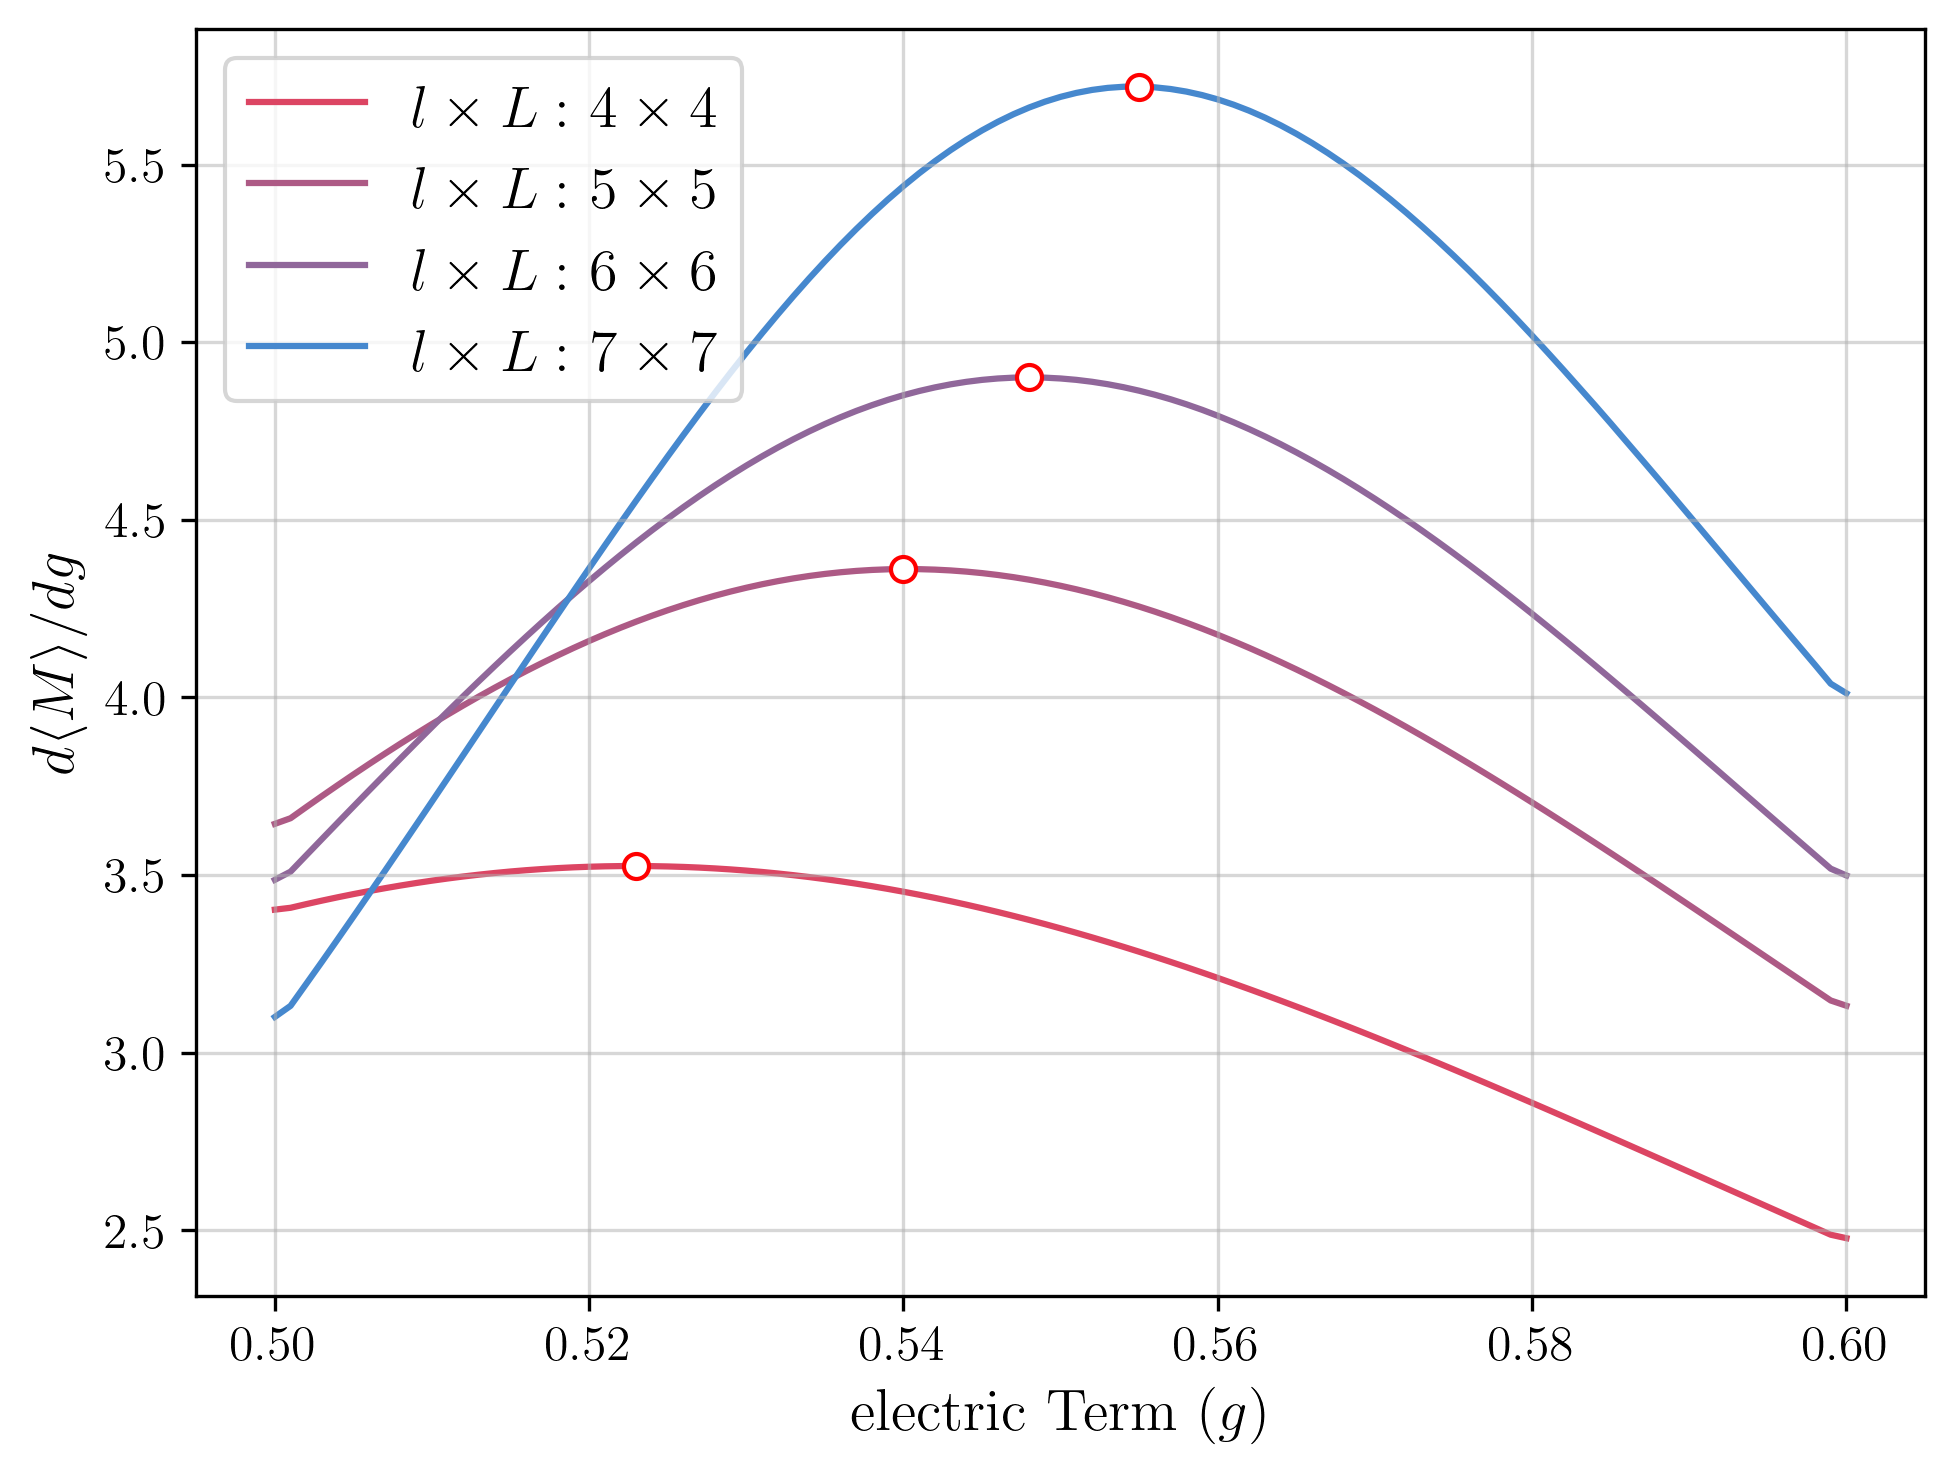

In [67]:
colors = ['#073b4c', '#06d6a0', '#118ab2', '#ef476f', '#ffd166']
colors = ['#99d98c', '#52b69a', '#168aad', '#1e6091']
colors = ["#DC4563","#AD5A85","#90679A", "#4688CE"]
# colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]
# colors = ['#177e89', '#084c61', '#db3a34', '#ffc857', '#ffd166']
# colors = ['#90e0ef', '#00b4d8', '#0077b6', '#03045e', '#fb8500'] # line dark, std light, data bright, g_th, g_fit
x_vals = plot_derivative_thooft_string_lattices(Ls, chis, lxs, lys, colors, ls)

In [68]:
x_vals

[0.523, 0.54, 0.548, 0.5549999999999999]

$$ \frac{dM}{dg} = |g_c^L - g_c^{\infty}|^{-\gamma} = a L^{\gamma/\nu} + const$$
$$ g_c^L - g_c^{\infty} = a L^{-1/\nu} = g_c^{\infty} + a \left(\frac{1}{L}\right)^{1/\nu}$$

In [69]:
# def pow_law(L,a,b,c):
#     return b + c*((1/L)**(1/a))

# x_vals_err = np.array([x_err]*len(x_vals))
# Ls_inv = [1/L for L in Ls]
# powp, powc = curve_fit(pow_law, Ls, x_vals, sigma=x_vals_err, absolute_sigma=True, bounds=([-2,0,-np.inf],[np.inf,1,np.inf]))
# perr = np.sqrt(np.diag(powc))
# print(f"Critical g: {powp[1]} +/- {perr[1]}")
# print(f"nu: {powp[0]} +/- {perr[0]}")

def pow_law(L,b,c,x):
    return b + c*(L**x)

x_vals_err = np.array([x_err]*len(x_vals))
Ls_inv = [1/L for L in Ls]
powp, powc = curve_fit(pow_law, Ls, x_vals, sigma=x_vals_err, absolute_sigma=True, bounds=([0,-np.inf,-2],[1,np.inf,np.inf]))
perr = np.sqrt(np.diag(powc))
print(f"Critical g: {powp[0]} +/- {perr[0]}")
print(f"nu: {-1/powp[2]} +/- {(1/(powp[2]-perr[2]) - 1/(powp[2]+perr[2]))/2}")

print("Parameter uncertainties:", perr)

Critical g: 0.5732671861852077 +/- 0.009751371670256252
nu: 0.5651815041784981 +/- 0.1907831048593576
Parameter uncertainties: [0.00975137 0.33056157 0.54134997]


In [ ]:
# Your given data
Ls = [4, 5, 6, 7]
Ls_inv = [1/4, 1/5, 1/6, 1/7]

# Power fit function
def pow_law(L,a,b,c):
    return a + b*(L**c)

# Error on x
x_err = (hx_f - hx_i) / npoints
crit_vals_err = np.array([x_err] * len(Ls_inv))

# Perform the linear fit
xdata = Ls
ydata = x_vals
p_opt, co_opt = curve_fit(pow_law, xdata, ydata, sigma=crit_vals_err, absolute_sigma=True, bounds=([0,-np.inf,-2],[1,np.inf,np.inf]))

# Extract the optimal parameters
a_opt, b_opt, c_opt = p_opt

# Extract the standard errors of the parameters
perr = np.sqrt(np.diag(co_opt))
a_err, b_err, c_err = perr

# Print the results
print(f"Optimal parameters: crit g = {a_opt:.4f} ± {a_err:.4f}, amplitude = {b_opt:.4f} ± {b_err:.4f}, nu = {-1/c_opt:.4f} ± {1/c_err:.4f}")

# Theoretical and fitted critical points
h_th = 1 / np.sqrt(3.044)
h_c = pow_law(L=0, a=p_opt[0], b=p_opt[1], c=-p_opt[2])
print(f"exp value of g_critical: {h_c}")

def plotting(p_opt, perr, xdata, ydata, crit_vals_err, colors):
    # Data for the fit line and error bounds
    xs = np.linspace(0, 0.3)
    y_fit = pow_law(xs, p_opt[0], p_opt[1], -p_opt[2])
    # error over nu
    nu_err = (1/(p_opt[2]-perr[2]) - 1/(p_opt[2]+perr[2]))/2
    y_err_plus = pow_law(xs, p_opt[0] + perr[0], p_opt[1] + perr[1], -p_opt[2] + nu_err)
    y_err_minus = pow_law(xs, p_opt[0] - perr[0], p_opt[1] - perr[1], -p_opt[2] - nu_err)

    # Plotting
    fig, ax = plt.subplots()
    ax.plot(xs, y_fit, color="k", linewidth=1, linestyle='--', label='Fit: $aL^{-1/\\nu} + b$', zorder=1)
    # ax.plot(xs, y_fit, color=colors[0], linewidth=1, label='Fit: $aL^{-1/\\nu} + b$')
    # ax.fill_between(xs, y_err_minus, y_err_plus, color=colors[1], alpha=0.5, label="Fit Uncertainty")
    ax.errorbar(xdata, ydata, yerr=crit_vals_err, fmt='o', elinewidth=1, capsize=8, markersize=8, mfc="white", mec="red", ecolor="red", label="Data", zorder=2)

    ax.scatter([0], [h_th], marker='x', color=colors[3], s=70, label="$g_c^{th}$",zorder=4)
    ax.errorbar([0], [h_c], yerr=perr[0], fmt='o', elinewidth=1, capsize=8, markersize=8, mfc="white", color=colors[4], label="$g_c^{fit}$", zorder=3)
    ax.set_xlabel("$1/L$", fontsize=14)
    ax.set_ylabel("electric coupling $(g)$", fontsize=14)
    # ax.grid(True, alpha=0.5)
    ax.legend(loc='upper right', fontsize=14)
    ax.set_ylim((0.42,0.64))
    
    # Inset plot
    inset_ax = inset_axes(ax, width="42%", height="45%", loc="lower left", bbox_to_anchor=(0.1, 0.09, 0.95, 0.9), bbox_transform=ax.transAxes)
    colors = ['#99d98c', '#52b69a', '#168aad', '#1e6091', '#d9ed92']
    colors = ["#4688CE","#9B4DB7","#DC4563"]
    colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]
    colors = ["#DC4563","#AD5A85","#90679A", "#4688CE"]


    i = 0
    Ls = [4,5,6,7]
    for L, chi, lx, ly in zip(Ls, chis, lxs, lys):
        l = L
        string = np.load(f"{parent_path}/results/thooft/thooft_string_first_moment_{lx}-{ly}_horizontal_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{hx_i}-{hx_f}_delta_{npoints}_chi_{chi}.npy")
        d_string_dh = np.gradient(string, interval)
        g_max = round(interval[np.argmax(d_string_dh)], 4)
        inset_ax.plot(interval, d_string_dh, color=colors[i], label=f"${l}$x${L}$", zorder=1)
        inset_ax.scatter(g_max, np.max(d_string_dh), marker='o', facecolors="white", edgecolors="red", zorder=2)
        i += 1

    # inset_ax.grid(True, alpha=0.5)
    inset_ax.legend(fontsize=10, loc='upper right')
    inset_ax.set_xlabel("electric coupling $(g)$",fontsize=14)
    inset_ax.set_ylabel("$d\langle M \\rangle / dg$", fontsize=14)
    inset_ax.tick_params(axis='both', which='major', labelsize=8)
    inset_ax.tick_params(axis='both', which='minor', labelsize=8)

    # Save the plot
    plt.savefig(f"{parent_path}/figures/magnetization/critical_point_Z2_dual_L_{Ls}_{sector}_bc_{boundcond}_None-None_h_{hx_i}-{hx_f}_delta_{npoints}_facecolor_white.png")

    plt.show()

Optimal parameters: crit g = 0.5733 ± 0.0098, amplitude = -0.5829 ± 0.3306, nu = 0.5652 ± 1.8472
exp value of g_critical: 0.5732671861852077


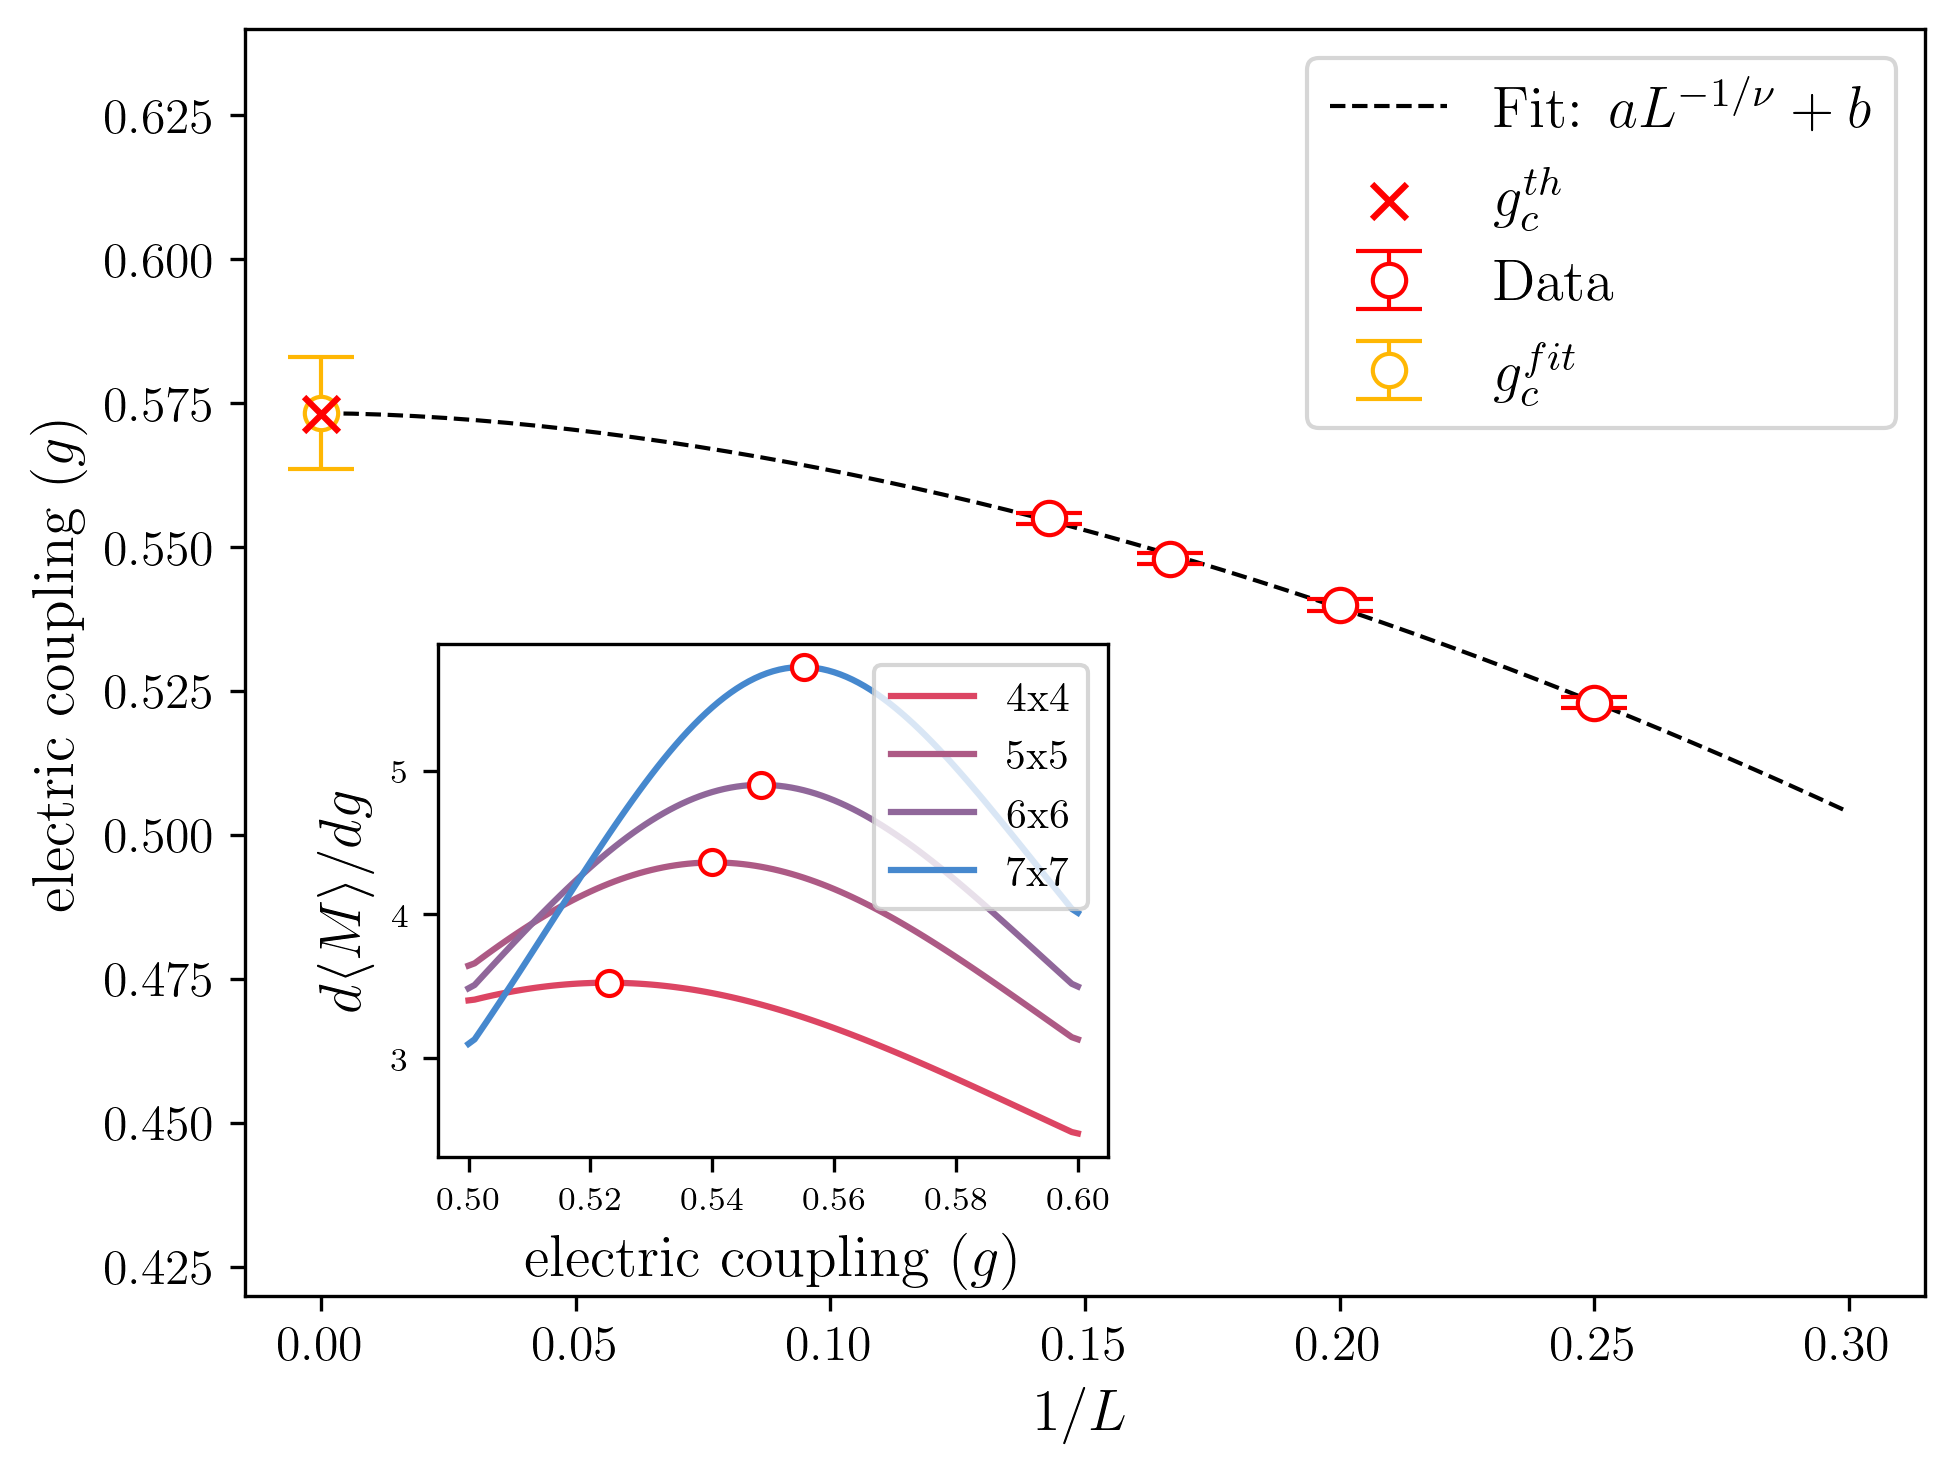

In [89]:
colors = ['#023047', '#8ECAE6', '#219EBC', 'red', '#FFB703'] # line dark, std light, data bright, g_th, g_fit
# colors = ['#8ECAE6', '#8ECAE6', '#023047', 'red', '#FFB703'] # line light, std light, data dark
# colors = ['#f4a261', '#e9c46a', '#2a9d8f', 'red', '#e76f51']
# colors = ['#073b4c', '#06d6a0', '#118ab2', '#ef476f', '#ffd166']

plotting(p_opt, perr, Ls_inv, ydata, crit_vals_err, colors)